<a href="https://colab.research.google.com/github/mohammap22/data-512-homework_1/blob/main/data_load_and_plotting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import json
import time
import urllib.parse
import requests
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [5]:
# Constants
# Read the CSV file into a DataFrame
df = pd.read_csv('/content/thank_the_academy.AUG.2023.csv - thank_the_academy.AUG.2023b.csv.csv')

# Extract the article titles into a list
ARTICLE_TITLES = df['name'].tolist()
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'
API_THROTTLE_WAIT = (1.0/100.0)-0.002
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}
START_DATE = "2015070100"
END_DATE = "2023093000"


In [6]:
# Initialize data storage dictionaries
mobile_data = defaultdict(dict)
desktop_data = defaultdict(dict)
cumulative_data = defaultdict(dict)

def request_pageviews_per_article(article_title, access_type):
    params = {
        "project": "en.wikipedia.org",
        "access": access_type,
        "agent": "user",
        "article": article_title,
        "granularity": "monthly",
        "start": START_DATE,
        "end": END_DATE
    }

    # Encode the article title
    params['article'] = urllib.parse.quote(params['article'].replace(' ', '_'))
    request_url = API_REQUEST_PAGEVIEWS_ENDPOINT + API_REQUEST_PER_ARTICLE_PARAMS.format(**params)

    # Make the request
    if API_THROTTLE_WAIT > 0.0:
        time.sleep(API_THROTTLE_WAIT)
    response = requests.get(request_url, headers=REQUEST_HEADERS)
    if response.status_code != 200:
        print(f"Error fetching data for {article_title} ({access_type}): {response.json()}")
        return None
    return response.json()['items']

In [8]:
for article in ARTICLE_TITLES:
    mobile_views = request_pageviews_per_article(article, "mobile-web")
    mobile_app_views = request_pageviews_per_article(article, "mobile-app")
    desktop_views = request_pageviews_per_article(article, "desktop")

    if not (mobile_views and mobile_app_views and desktop_views):
        print(f"Skipping {article} due to incomplete data.")
        continue

    for month_data in mobile_views:
        timestamp = month_data['timestamp']
        mobile_data[article][timestamp] = month_data['views']
        cumulative_data[article][timestamp] = month_data['views']

    for month_data in mobile_app_views:
        timestamp = month_data['timestamp']
        mobile_data[article][timestamp] += month_data['views']
        cumulative_data[article][timestamp] += month_data['views']

    for month_data in desktop_views:
        timestamp = month_data['timestamp']
        desktop_data[article][timestamp] = month_data['views']
        cumulative_data[article][timestamp] += month_data['views']

# Save data to JSON files
with open("academy_monthly_mobile_201507-202309.json", "w") as f:
    json.dump(mobile_data, f)

with open("academy_monthly_desktop_201507-202309.json", "w") as f:
    json.dump(desktop_data, f)

with open("academy_monthly_cumulative_201507-202309.json", "w") as f:
    json.dump(cumulative_data, f)

Error fetching data for Victor/Victoria (mobile-web): {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-web/user/Victor/Victoria/monthly/2015070100/2023093000'}
Error fetching data for Victor/Victoria (mobile-app): {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/mobile-app/user/Victor/Victoria/monthly/2015070100/2023093000'}
Error fetching data for Victor/Victoria (desktop): {'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found#route', 'title': 'Not found.', 'method': 'get', 'uri': '/wikimedia.org/v1/metrics/pageviews/per-article/en.wikipedia.org/desktop/user/Victor/Victoria/monthly/2015070100/2023093000'}
Skipping Victor/Victoria due to incomplete data.


In [28]:
# Reload the JSON data into Python dictionaries
with open('/content/academy_monthly_mobile_201507-202309.json', 'r') as f:
    mobile_data = json.load(f)

with open('/content/academy_monthly_desktop_201507-202309.json', 'r') as f:
    desktop_data = json.load(f)

with open('/content/academy_monthly_cumulative_201507-202309.json', 'r') as f:
    cumulative_data = json.load(f)


In [43]:
# HELPER FUNCTIONS

def format_timestamps(timestamps):
    return [datetime.strptime(str(t)[:6], "%Y%m").strftime("%b %Y") for t in timestamps]

# Function to align the data for two articles so they have the same set of timestamps
def align_data(article1_data, article2_data):
    common_timestamps = set(article1_data.keys()).intersection(set(article2_data.keys()))
    aligned_data1 = {k: article1_data[k] for k in common_timestamps}
    aligned_data2 = {k: article2_data[k] for k in common_timestamps}
    return aligned_data1, aligned_data2
# Function to sort the data based on the timestamps
def sort_data_by_timestamps(data):
    sorted_data = dict(sorted(data.items()))
    return sorted_data
# Function to calculate the average monthly pageviews for each article
def calculate_average_pageviews(data):
    average_pageviews = {}
    for article, views in data.items():
        average_pageviews[article] = np.mean(list(views.values()))
    return average_pageviews
# Function to find the JSON object with the most timestamps among multiple JSON objects
def find_longest_timestamps(*data_dicts):
    longest_data = max(data_dicts, key=lambda x: len(x.keys()))
    return list(longest_data.keys())

# Function to align data with a given set of timestamps
def align_data_with_timestamps(data, timestamps):
    return {timestamp: data.get(timestamp, 0) for timestamp in timestamps}

# Function to sort a dictionary by its keys (timestamps)
def sort_data_by_timestamps(data):
    return {k: v for k, v in sorted(data.items())}

# Function to format timestamps into a more human-readable form (YYYY-MM to Month Year)
def format_timestamps(timestamps):
    months = {
        "01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr",
        "05": "May", "06": "Jun", "07": "Jul", "08": "Aug",
        "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"
    }
    return [f"{months[t[4:6]]} {t[:4]}" for t in timestamps]

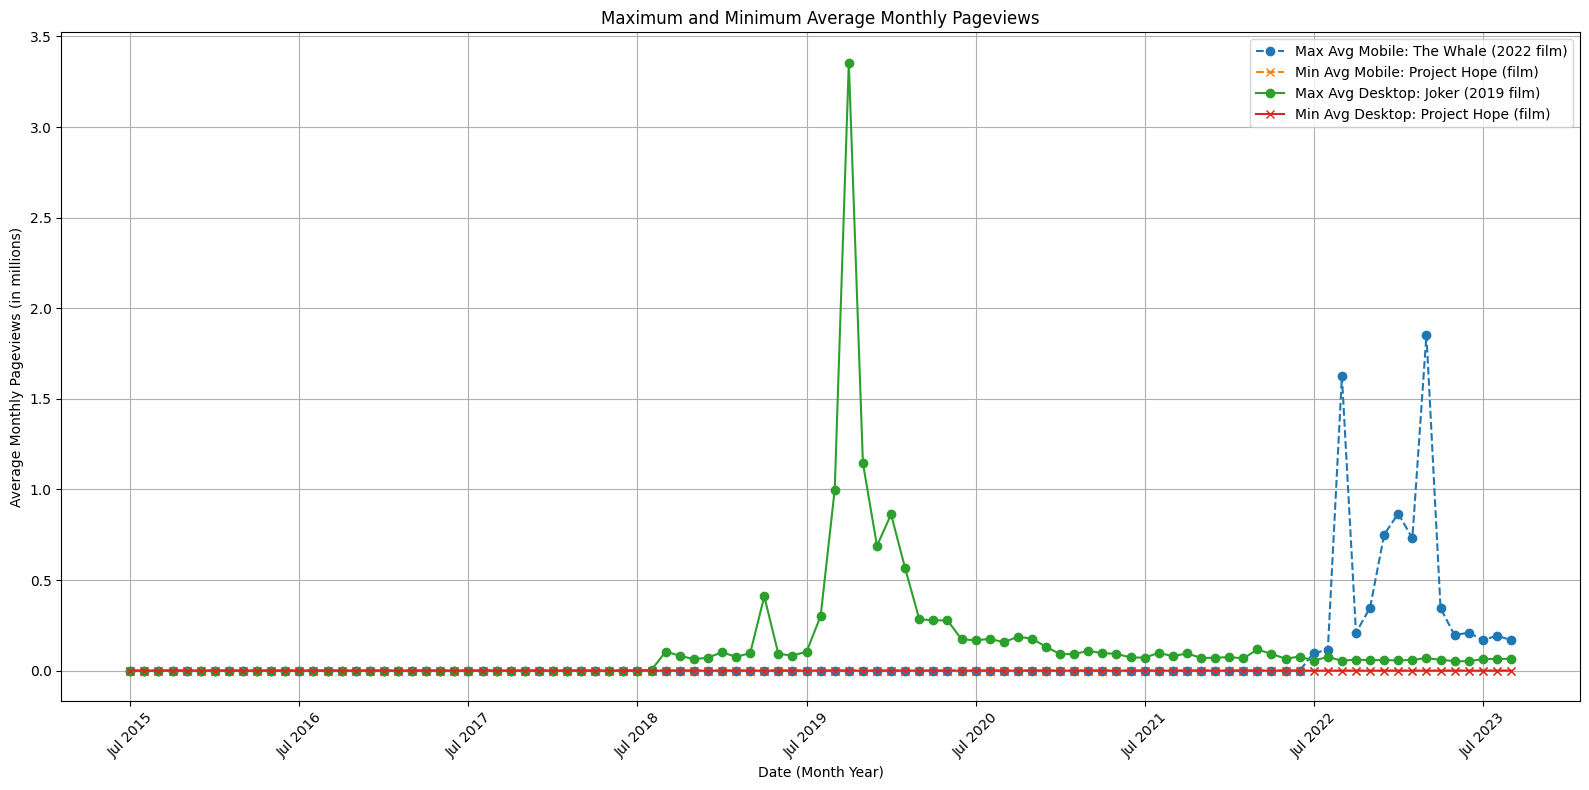

In [44]:
average_mobile_pageviews = calculate_average_pageviews(mobile_data)
average_desktop_pageviews = calculate_average_pageviews(desktop_data)
max_avg_mobile_article = max(average_mobile_pageviews, key=average_mobile_pageviews.get)
min_avg_mobile_article = min(average_mobile_pageviews, key=average_mobile_pageviews.get)
max_avg_desktop_article = max(average_desktop_pageviews, key=average_desktop_pageviews.get)
min_avg_desktop_article = min(average_desktop_pageviews, key=average_desktop_pageviews.get)

# Find the longest set of timestamps among the four JSON objects (max and min for both mobile and desktop)
longest_timestamps = find_longest_timestamps(mobile_data[max_avg_mobile_article], mobile_data[min_avg_mobile_article], desktop_data[max_avg_desktop_article], desktop_data[min_avg_desktop_article])

# Align and sort the data for max and min articles for both mobile and desktop
aligned_max_mobile = align_data_with_timestamps(mobile_data[max_avg_mobile_article], longest_timestamps)
aligned_min_mobile = align_data_with_timestamps(mobile_data[min_avg_mobile_article], longest_timestamps)
aligned_max_desktop = align_data_with_timestamps(desktop_data[max_avg_desktop_article], longest_timestamps)
aligned_min_desktop = align_data_with_timestamps(desktop_data[min_avg_desktop_article], longest_timestamps)

sorted_aligned_max_mobile = sort_data_by_timestamps(aligned_max_mobile)
sorted_aligned_min_mobile = sort_data_by_timestamps(aligned_min_mobile)
sorted_aligned_max_desktop = sort_data_by_timestamps(aligned_max_desktop)
sorted_aligned_min_desktop = sort_data_by_timestamps(aligned_min_desktop)

# Prepare data for plotting
sorted_aligned_timestamps = format_timestamps(list(sorted_aligned_max_mobile.keys()))
sorted_max_mobile_views = np.array(list(sorted_aligned_max_mobile.values())) / 1e6  # Convert to millions
sorted_min_mobile_views = np.array(list(sorted_aligned_min_mobile.values())) / 1e6  # Convert to millions
sorted_max_desktop_views = np.array(list(sorted_aligned_max_desktop.values())) / 1e6  # Convert to millions
sorted_min_desktop_views = np.array(list(sorted_aligned_min_desktop.values())) / 1e6  # Convert to millions

# Plot for mobile and desktop data on the same plot
plt.figure(figsize=(16, 8))

plt.plot(sorted_aligned_timestamps, sorted_max_mobile_views, label=f"Max Avg Mobile: {max_avg_mobile_article}", linestyle='--', marker='o')
plt.plot(sorted_aligned_timestamps, sorted_min_mobile_views, label=f"Min Avg Mobile: {min_avg_mobile_article}", linestyle='--', marker='x')
plt.plot(sorted_aligned_timestamps, sorted_max_desktop_views, label=f"Max Avg Desktop: {max_avg_desktop_article}", linestyle='-', marker='o')
plt.plot(sorted_aligned_timestamps, sorted_min_desktop_views, label=f"Min Avg Desktop: {min_avg_desktop_article}", linestyle='-', marker='x')

plt.xlabel('Date (Month Year)')
plt.ylabel('Average Monthly Pageviews (in millions)')
plt.title('Maximum and Minimum Average Monthly Pageviews')
plt.xticks(sorted_aligned_timestamps[::12], rotation=45)  # Show one tick per year for clarity
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('min_max_avrg_monthy_views.png')
plt.show()



In [ ]:
# Function to find the article pages with the top 10 peak page views
def find_top_10_peak_articles(data):
    peak_views = {}
    for article, views in data.items():
        peak_views[article] = max(views.values())
    return sorted(peak_views, key=peak_views.get, reverse=True)[:10]

# Find the top 10 articles by peak page views for mobile and desktop
top_10_peak_mobile_articles = find_top_10_peak_articles(mobile_data)
top_10_peak_desktop_articles = find_top_10_peak_articles(desktop_data)

# Find the longest set of timestamps among the top 10 articles for both mobile and desktop
longest_timestamps_top_10 = find_longest_timestamps(
    *[mobile_data[article] for article in top_10_peak_mobile_articles],
    *[desktop_data[article] for article in top_10_peak_desktop_articles]
)

# Align and sort the data for the top 10 articles for both mobile and desktop
aligned_top_10_mobile = {article: align_data_with_timestamps(mobile_data[article], longest_timestamps_top_10) for article in top_10_peak_mobile_articles}
aligned_top_10_desktop = {article: align_data_with_timestamps(desktop_data[article], longest_timestamps_top_10) for article in top_10_peak_desktop_articles}

sorted_aligned_top_10_mobile = {article: sort_data_by_timestamps(views) for article, views in aligned_top_10_mobile.items()}
sorted_aligned_top_10_desktop = {article: sort_data_by_timestamps(views) for article, views in aligned_top_10_desktop.items()}

# Prepare data for plotting
sorted_aligned_timestamps_top_10 = format_timestamps(list(longest_timestamps_top_10))

# Plot for the top 10 peak page views articles for both mobile and desktop
plt.figure(figsize=(20, 10))

for article, views in sorted_aligned_top_10_mobile.items():
    plt.plot(sorted_aligned_timestamps_top_10, np.array(list(views.values())) / 1e6, label=f"Mobile: {article}", linestyle='--')

for article, views in sorted_aligned_top_10_desktop.items():
    plt.plot(sorted_aligned_timestamps_top_10, np.array(list(views.values())) / 1e6, label=f"Desktop: {article}", linestyle='-')

plt.xlabel('Date (Month Year)')
plt.ylabel('Peak Pageviews (in millions)')
plt.title('Top 10 Peak Page Views for Mobile and Desktop')
plt.xticks(sorted_aligned_timestamps_top_10[::12], rotation=45)  # Show one tick per year for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('top_10_peak_views.png')
plt.show()


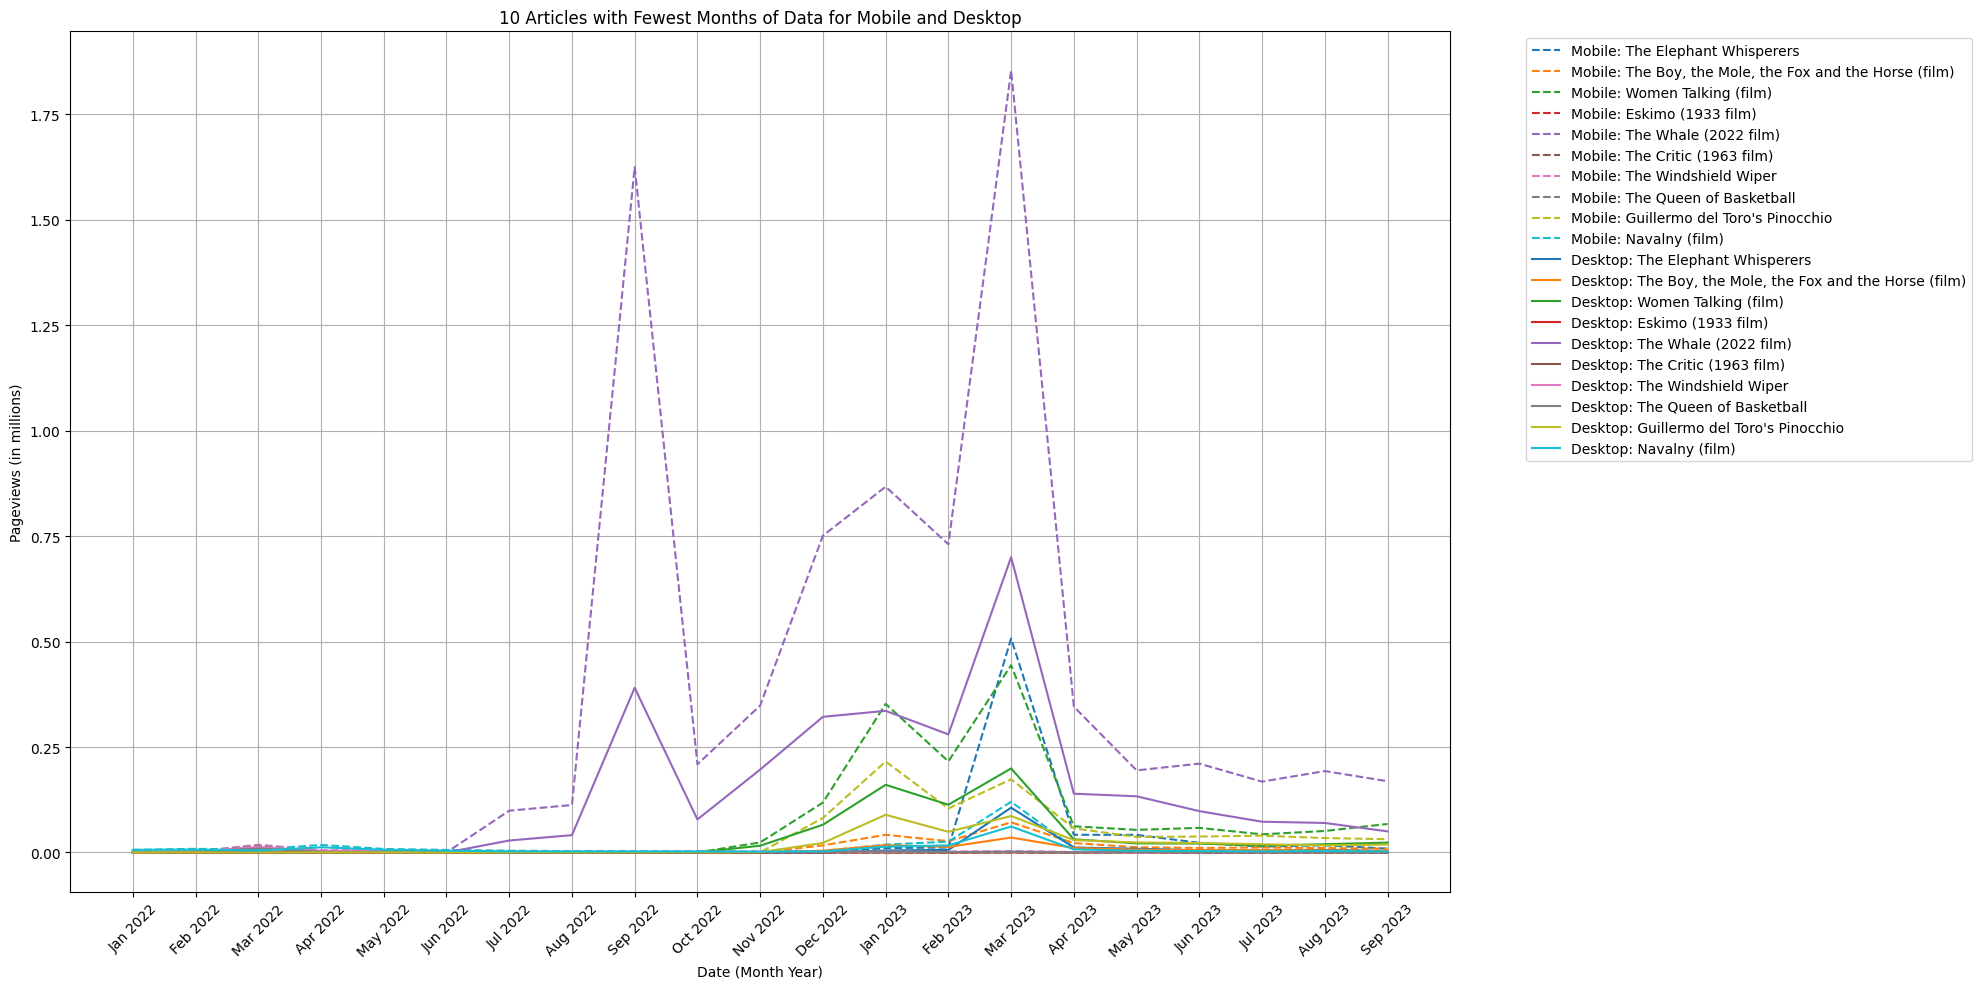

In [50]:
# Function to find the articles with the fewest months of available data
def find_fewest_months_articles(data):
    fewest_months = {}
    for article, views in data.items():
        fewest_months[article] = len(views)
    return sorted(fewest_months, key=fewest_months.get)[:10]

# Find the 10 articles with the fewest months of data for mobile and desktop
fewest_months_mobile_articles = find_fewest_months_articles(mobile_data)
fewest_months_desktop_articles = find_fewest_months_articles(desktop_data)

# Find the longest set of timestamps among the 10 articles with fewest months for both mobile and desktop
longest_timestamps_fewest_months = find_longest_timestamps(
    *[mobile_data[article] for article in fewest_months_mobile_articles],
    *[desktop_data[article] for article in fewest_months_desktop_articles]
)

# Align and sort the data for the 10 articles with fewest months for both mobile and desktop
aligned_fewest_months_mobile = {article: align_data_with_timestamps(mobile_data[article], longest_timestamps_fewest_months) for article in fewest_months_mobile_articles}
aligned_fewest_months_desktop = {article: align_data_with_timestamps(desktop_data[article], longest_timestamps_fewest_months) for article in fewest_months_desktop_articles}

sorted_aligned_fewest_months_mobile = {article: sort_data_by_timestamps(views) for article, views in aligned_fewest_months_mobile.items()}
sorted_aligned_fewest_months_desktop = {article: sort_data_by_timestamps(views) for article, views in aligned_fewest_months_desktop.items()}

# Prepare data for plotting
sorted_aligned_timestamps_fewest_months = format_timestamps(list(longest_timestamps_fewest_months))

# Plot for the 10 articles with fewest months of data for both mobile and desktop
plt.figure(figsize=(20, 10))

for article, views in sorted_aligned_fewest_months_mobile.items():
    plt.plot(sorted_aligned_timestamps_fewest_months, np.array(list(views.values())) / 1e6, label=f"Mobile: {article}", linestyle='--')

for article, views in sorted_aligned_fewest_months_desktop.items():
    plt.plot(sorted_aligned_timestamps_fewest_months, np.array(list(views.values())) / 1e6, label=f"Desktop: {article}", linestyle='-')

plt.xlabel('Date (Month Year)')
plt.ylabel('Pageviews (in millions)')
plt.title('10 Articles with Fewest Months of Data for Mobile and Desktop')
plt.xticks(sorted_aligned_timestamps_fewest_months, rotation=45)  # Show all ticks for clarity
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.savefig('fewest_month_data.png')
plt.show()
